In [ ]:
# !pip install imblearn

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow import keras
import matplotlib.pyplot as plot
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE

Using TensorFlow backend.


In [3]:
np_Images = np.load('./dataset/Image_224.npy') #converting the list of images to numpy array.
np_Labels = np.load('./dataset/Label_224.npy')

In [ ]:
%reset

In [3]:
print("Shape of Images:",np_Images.shape)
print("Shape of Labels:",np_Labels.shape)

Shape of Images: (16785, 224, 224, 3)
Shape of Labels: (16785,)


In [4]:
np.bincount(np_Labels)

array([9955,  229,  766, 2061,  426, 3348])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
len(np_Images)

16785

In [ ]:
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(np_Images, np_Labels, test_size=0.1, random_state=1, stratify=np_Labels)

In [ ]:
X_train_tmp_1, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=0.11, random_state=1 ,stratify=y_train_tmp)

In [ ]:
np.bincount(y_train)

In [ ]:
X_train_smote = X_train_tmp_1.reshape((X_train_tmp_1.shape[0], X_train_tmp_1.shape[1] * X_train_tmp_1.shape[2] * X_train_tmp_1.shape[3])).astype(np.float32)

In [ ]:
smote = BorderlineSMOTE(n_jobs=8)
X_train, y_train = smote.fit_resample(X_train_smote, y_train)

In [ ]:
len(X_train), len(y_train)

In [ ]:
np.bincount(y_train)

In [ ]:
X_train = X_train.reshape((-1, np_Images.shape[1], np_Images.shape[2], np_Images.shape[3])).astype(np.float32)

In [ ]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [ ]:
plot.imshow(X_train[47837]/255)
plot.show()

In [ ]:
list_1 = []
for idx, label in enumerate(y_train):
    if label == 1:
        list_1.append(idx)

In [ ]:
image_list = list_1[7000:7052]
plot.figure(figsize=(20,70))

for idx, img in enumerate(image_list):
    plot.subplot(13,4,idx+1)
    plot.imshow(X_train[img]/255)
    plot.title(idx+1)
    plot.axis("off")
plot.show()

In [ ]:
X_train.shape, y_train.shape

In [ ]:
# Images = (Images / 127.5) -1

In [ ]:
np.bincount(y_train)

In [ ]:
names =  {0: 'Tomato_H', 1: 'Tomato_D01', 2: 'Tomato_D04', 3: 'Tomato_D05',
              4: 'Tomato_D08', 5: 'Tomato_P03'}

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
np.bincount(y_train),np.bincount(y_test)

In [3]:
IMG_SHAPE = X_train[0].shape

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,   
                                            weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
test_batch = tf.convert_to_tensor(X_train[0:4])
test_batch

<tf.Tensor 'Const:0' shape=(4, 224, 224, 3) dtype=float32>

In [5]:
feature_batch = base_model(test_batch)
print(feature_batch.shape)

(4, 7, 7, 1280)


In [6]:
# base_model.trainable = False

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


In [9]:
prediction_layer = keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 6)


In [10]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
# class_weights

In [13]:
# class_weight = {}

# for i in range(6):
#     class_weight[i] = class_weights[i]
    
# class_weight

In [14]:
# class_weight = [np.sqrt(np.sqrt(i)) for i in class_weights]
# class_weight

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
model.trainable_variables

[<tf.Variable 'Conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32>,
 <tf.Variable 'bn_Conv1/gamma:0' shape=(32,) dtype=float32>,
 <tf.Variable 'bn_Conv1/beta:0' shape=(32,) dtype=float32>,
 <tf.Variable 'expanded_conv_depthwise/depthwise_kernel:0' shape=(3, 3, 32, 1) dtype=float32>,
 <tf.Variable 'expanded_conv_depthwise_BN/gamma:0' shape=(32,) dtype=float32>,
 <tf.Variable 'expanded_conv_depthwise_BN/beta:0' shape=(32,) dtype=float32>,
 <tf.Variable 'expanded_conv_project/kernel:0' shape=(1, 1, 32, 16) dtype=float32>,
 <tf.Variable 'expanded_conv_project_BN/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'expanded_conv_project_BN/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'block_1_expand/kernel:0' shape=(1, 1, 16, 96) dtype=float32>,
 <tf.Variable 'block_1_expand_BN/gamma:0' shape=(96,) dtype=float32>,
 <tf.Variable 'block_1_expand_BN/beta:0' shape=(96,) dtype=float32>,
 <tf.Variable 'block_1_depthwise/depthwise_kernel:0' shape=(3, 3, 96, 1) dtype=float32>,
 <tf.Variable 'blo

In [17]:
callback = [keras.callbacks.ModelCheckpoint('./checkpoint', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1),
            keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]

In [18]:
trained = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val,y_val), callbacks=callback)

Train on 47838 samples, validate on 1662 samples
Epoch 1/20
47838/47838 [==============================] - 340s 7ms/sample - loss: 0.0748 - acc: 0.9762 - val_loss: 0.0693 - val_acc: 0.9777
Epoch 2/20
47838/47838 [==============================] - 271s 6ms/sample - loss: 0.0130 - acc: 0.9963 - val_loss: 0.0814 - val_acc: 0.9832


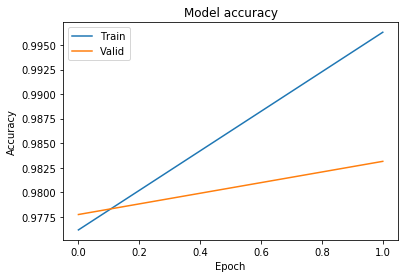

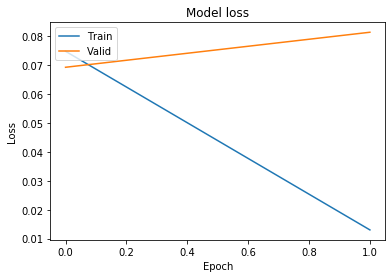

In [22]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

In [20]:
# test_images,test_labels = get_images('./test/')
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)
model.evaluate(X_test,y_test, verbose=1)

1679/1679 [==============================] - 10s 6ms/sample - loss: 0.1006 - acc: 0.9720


[0.10057604945060007, 0.97200716]

In [21]:
model.save('97_2_per_mobilenet_v2.h5')